In [214]:
from __future__ import print_function
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [215]:
# open feature engineered dataframe
with open('df_X.pickle', 'rb') as read_file:
    df_X = pickle.load(read_file)
    

In [137]:
# original order_train file from instacart
train_df = pd.read_csv('/Users/KC/Documents/Metis/Instacart_Project3/instacart_2017_05_01/order_products__train.csv')

In [138]:
# original orders file from instacart
orders_df = pd.read_csv('/Users/KC/Documents/Metis/Instacart_Project3/instacart_2017_05_01/orders_clean.csv')

In [139]:
# merging order_train with orders file
train_orders = train_df.merge(orders_df.drop('eval_set',axis=1), on='order_id')

In [140]:
## taking only 20% of user_ids from train to get a smaller dataset
def get_smaller_data(df,seed=42):
    rs = np.random.RandomState(seed)
    train_ids = df['user_id'].unique() 
    train_users = rs.choice(train_ids, 
                               size=int(train_ids.shape[0] * .2), 
                               replace=False)
    smaller_df = df[df['user_id'].isin(train_users)]
    return train_users, smaller_df


In [141]:
train_ids, smaller_df = get_smaller_data(train_orders)

In [142]:
# new list of user ids to be used in modeling
train_ids.shape

(26241,)

In [282]:
# filtering df_X model dataframe with train_ids
df_X = df_X[df_X['user_id'].isin(train_ids)]

In [283]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1694939 entries, 0 to 1694938
Data columns (total 16 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   product_id                       int64  
 1   user_id                          int64  
 2   latest_cart                      object 
 3   will_order                       int64  
 4   user_total_orders                float64
 5   user_avg_cartsize                float64
 6   user_total_products              float64
 7   user_avg_days_since_prior_order  float64
 8   user_avg_reorder_ratio           float64
 9   prod_total_orders                int64  
 10  prod_avg_add_to_cart_order       int64  
 11  prod_avg_days_since_prior_order  float64
 12  user_prod_avg_cart_order         float64
 13  user_prod_total_orders           int64  
 14  user_prod_order_freq             float64
 15  user_prod_latest_perc            float64
dtypes: float64(9), int64(6), object(1)
memory usage: 219.8

### Train Test Split with Smaller df_X

In [218]:
def get_user_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    total_users = df['user_id'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['user_id'].isin(test_users)]
    df_te = df[df['user_id'].isin(test_users)] 

    y_tr, y_te = df_tr['will_order'], df_te['will_order']
    X_tr = df_tr.drop(['product_id','user_id','latest_cart','will_order'],axis=1) 
    X_te = df_te.drop(['product_id','user_id','latest_cart','will_order'],axis=1)

    return X_tr, X_te, y_tr, y_te, df_tr,df_te


In [219]:
X_tr, X_te, y_tr, y_te, df_train, df_test = get_user_split_data(df_X)


### Split Train into Train & Validation

In [220]:
def get_user_split_val(df, test_size=.25, seed=42):

    rs = np.random.RandomState(seed)
    total_users = df['user_id'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['user_id'].isin(test_users)]
    df_te = df[df['user_id'].isin(test_users)] 

    y_tr, y_val = df_tr['will_order'], df_te['will_order']
    X_tr = df_tr.drop(['product_id','user_id','latest_cart','will_order'],axis=1) 
    X_val = df_te.drop(['product_id','user_id','latest_cart','will_order'],axis=1)

    return X_tr, X_val, y_tr, y_val


In [221]:
X_train, X_val, y_train, y_val = get_user_split_val(df_train)


In [222]:
X_tr.shape


(1349738, 12)

In [223]:
X_train.shape


(1011158, 12)

In [224]:
Counter(y_train)


Counter({0: 911853, 1: 99305})

## Undersampling of Data (due to class imbalance & computational power)

In [154]:

from collections import Counter

In [240]:
from imblearn.under_sampling import RandomUnderSampler
#imbalance and because want to be able to run data
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(X_train,y_train)


In [241]:
Counter(y_under)


Counter({0: 99305, 1: 99305})

In [77]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0)
# X_resampled, y_resampled = ros.fit_sample(X_tr,y_tr)

In [78]:
# # Yay, balanced classes!
# Counter(y_resampled)

Counter({0: 1219091, 1: 1219091})

In [79]:
# from imblearn.over_sampling import ADASYN
# X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_tr,y_tr)

In [80]:
# # Check that our dataset is reasonably balanced
# Counter(y_adasyn)

Counter({0: 1219091, 1: 1245461})

### Steps for K-fold cross-validation
* Split the dataset into K equal partitions (or "folds").
* Use fold 1 as the testing set and the union of the other folds as   the training set.
* Calculate testing accuracy.
* Repeat steps 2 and 3 K times, using a different fold as the       testing set each time.
* Use the average testing accuracy as the estimate of out-of-sample accuracy.

In [226]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='f1')
print(scores)


[0.15346048 0.07270045 0.02022571]


In [227]:
# use average as an estimate of out-of-sample accuracy
print(scores.mean())

0.0821288796628452


In [164]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
    k_scores.append(scores.mean())
print(k_scores)


[0.3206984352470992, 0.19862747483487045, 0.3119088158336948, 0.22823472686498417, 0.3043863040315072, 0.2377226828311388, 0.298403401793573, 0.24352176693800284, 0.2962039327851256, 0.24600741232890014, 0.2926944915743622, 0.247825288264829, 0.28990566283357977, 0.250292216895165, 0.28791357608418455, 0.2523245560452744, 0.28651199570513325, 0.252718341418552, 0.2852585445701894, 0.25444793216604217, 0.2836106046557179, 0.2554039592030213, 0.28282843187792034, 0.25571281665537493, 0.28175049056993906, 0.257045989702515, 0.2817409019139716, 0.2571084164576358, 0.2807094790972695, 0.25741178350051463]


Text(0, 0.5, 'Cross-Validated Accuracy')

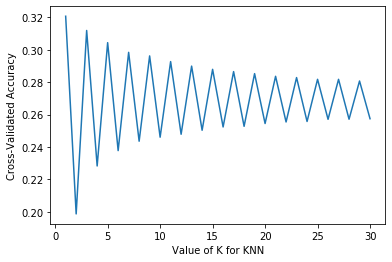

In [285]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')


In [286]:
# repeat KNN with best n = 2
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_under, y_under)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [292]:
# KNN accuracy scores with Undersampled X & y
knn_u = KNeighborsClassifier(n_neighbors=3)
knn_u.fit(X_under, y_under)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn_u.score(X_under, y_under)))
print("Test set: {:6.2f}%".format(100*knn_u.score(X_val, y_val)))


The score for kNN is
Training:  79.67%
Test set:  61.99%


In [289]:
# KNN accuracy scores with non-adjusted X & y (smaller X train b/c of val)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_val, y_val)))


The score for kNN is
Training:  92.13%
Test set:  88.90%


In [290]:
from sklearn.metrics import confusion_matrix

print("kNN confusion matrix: \n\n", confusion_matrix(y_val, knn.predict(X_val)))


kNN confusion matrix: 

 [[297868   8071]
 [ 29497   3144]]


In [374]:
# Print confusion matrix for kNN NO undersampling
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    order_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(order_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['wont order', 'will_order'],
           yticklabels=['wont_order', 'will_order']);
    plt.title(model,'Confusion Matrix')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    

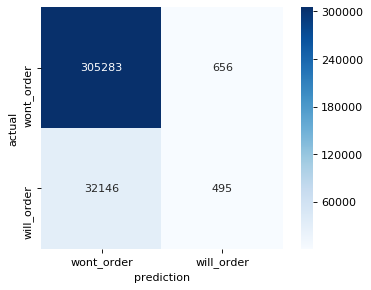

In [291]:
# KNN without undersampling
make_confusion_matrix(knn,threshold=0.7)


In [234]:
# Print confusion matrix for kNN with undersampling
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    order_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(order_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['wont_order','will_order'],
           yticklabels=['wont_order', 'will_order']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    

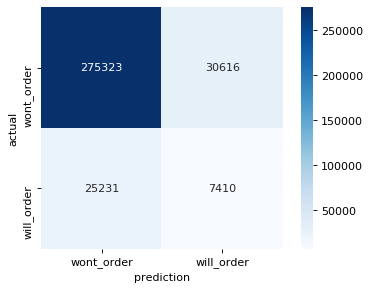

In [296]:
make_confusion_matrix(knn_u,threshold=0.7)


In [297]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_val, knn.predict_proba(X_val)[:,1])


ROC AUC score =  0.5941899775752716


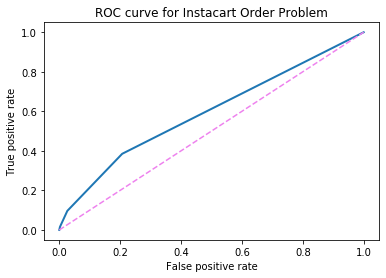

In [298]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Instacart Order Problem');
print("ROC AUC score = ", roc_auc_score(y_val, knn.predict_proba(X_val)[:,1]))


In [173]:
# from sklearn.metrics import roc_auc_score, roc_curve

# fpr, tpr, thresholds = roc_curve(y_val, knn.predict_proba(X_val)[:,1])

ROC AUC score =  0.6494939942310602


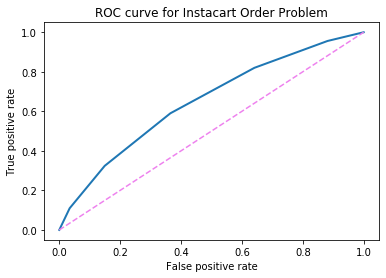

In [174]:
# slightly worse ROC AUC score of 0.616 with unadjusted train values
# plt.plot(fpr, tpr,lw=2)
# plt.plot([0,1],[0,1],c='violet',ls='--')
# plt.xlim([-0.05,1.05])
# plt.ylim([-0.05,1.05])

# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve for Instacart Order Problem');
# print("ROC AUC score = ", roc_auc_score(y_val, knn.predict_proba(X_val)[:,1]))

### Random Forest Models

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [264]:
randomforest2 = RandomForestClassifier(n_estimators=100)
randomforest2.fit(X_under, y_under)
randomforest2.score(X_val,y_val)
# undersampled - accuracy : 0.7484612203910449

0.7484612203910449

In [265]:
y_predict = randomforest2.predict(X_val)
f1_score(y_val, y_predict)
# undersampled - f1 : 0.35193583734096306

0.35193583734096306

In [266]:
# Random Forest without undersampling
randomforest = RandomForestClassifier(n_estimators=100)
randomforest.fit(X_train, y_train)
randomforest.score(X_val,y_val)
# accurary : 0.9084322759761356

0.9084322759761356

In [267]:
## Random Forest without undersampling
y_predict = randomforest.predict(X_val)
f1_score(y_val, y_predict)
# f1 : 0.24941290400677887

0.24941290400677887

In [268]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_val, randomforest2.predict_proba(X_val)[:,1])


ROC AUC score =  0.8066193752719197


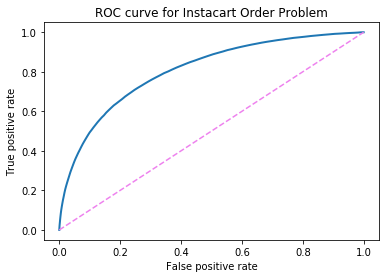

In [269]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Instacart Order Problem');
print("ROC AUC score = ", roc_auc_score(y_val, randomforest2.predict_proba(X_val)[:,1]))
# underfit - roc auc : 0.8066193752719197

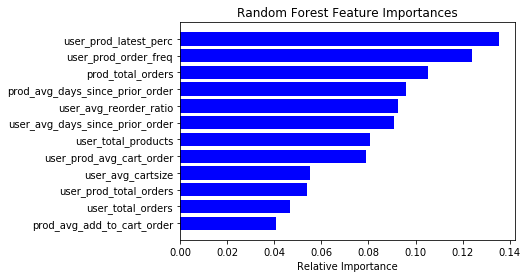

In [271]:
features = X_under.columns
importances = randomforest2.feature_importances_
indices = np.argsort(importances)

plt.title('Random Forest Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

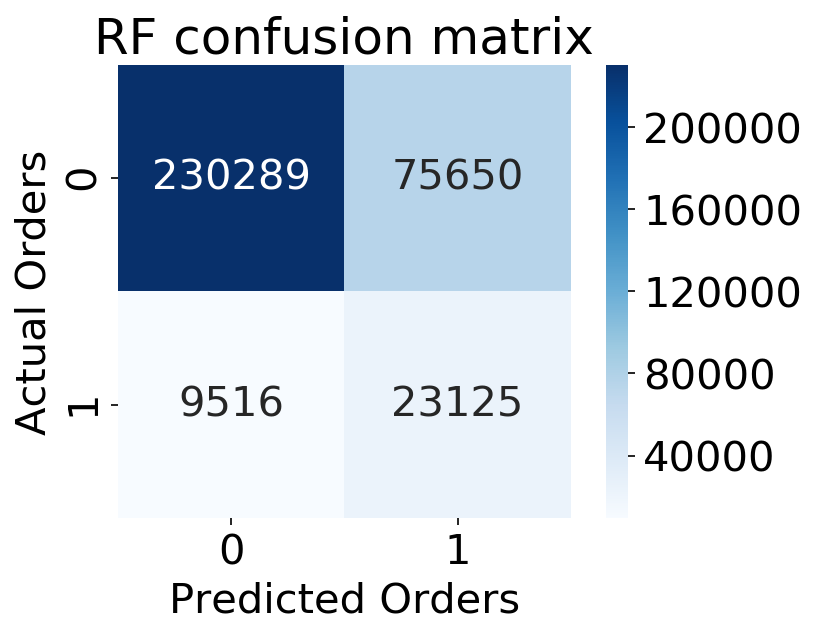

In [368]:
# Print confusion matrix for random forest
from sklearn.metrics import confusion_matrix
rf_confusion = confusion_matrix(y_val, randomforest2.predict(X_val))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

plt.xlabel('Predicted Orders')
plt.ylabel('Actual Orders')
plt.title('RF confusion matrix');

## Logistic Regression

In [250]:
logit = LogisticRegression(solver='liblinear',C = 0.01)
logit.fit(X_train, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_val, y_val)))

The score for logistic regression is
Training:  90.35%
Test set:  90.53%


In [251]:
# undersampled data
logit2 = LogisticRegression(solver='liblinear',C = 0.01)
logit2.fit(X_under, y_under)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_under, y_under)))
print("Test set: {:6.2f}%".format(100*logit.score(X_val, y_val)))

The score for logistic regression is
Training:  53.03%
Test set:  90.53%


In [253]:
std_scale = StandardScaler()

#X_train = X_under[['user_prod_order_freq', 'prod_total_orders']]
X_train_scaled = std_scale.fit_transform(X_under)

lm3 = LogisticRegression(solver='liblinear',C=0.01)
lm3.fit(X_train_scaled, y_under)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [256]:
lm3.score(X_train_scaled, y_under)

0.7295352701273853

In [258]:
y_predict_logit = lm3.predict(X_val)
f1_score(y_val,y_predict_logit)
# logistic regression score = accuracy

0.1827368638511662

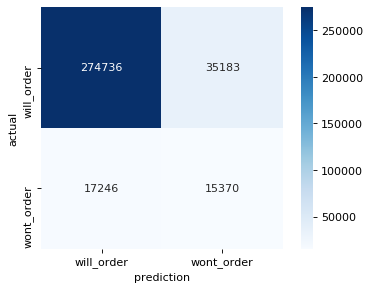

In [141]:
make_confusion_matrix(logit,threshold=0.6)

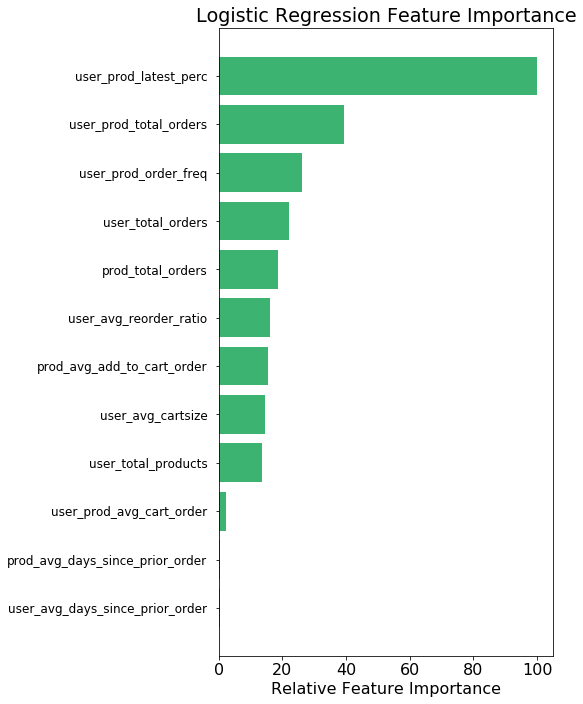

In [422]:
# plotting feature importance for logistic regression
feature_importance = abs(lm3.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(8,10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center', color='mediumseagreen')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train.columns)[sorted_idx], fontsize=12)
featax.set_xlabel('Relative Feature Importance',)
plt.title('Logistic Regression Feature Importance')
plt.rcParams.update({'font.size': 14})
plt.tight_layout()   
plt.show()

## SVM

In [ ]:
# too big, won't run
# from sklearn import svm

# svm_model = svm.SVC(kernel="linear")
# svm_model.fit(X_under, y_under)

# plot_decision_boundary(
#     svm_model.predict,
#     x=blob_df[["x0", "x1"]].values,
#     y=blob_df["y"].values,
#     points=1e4, margin_func=svm_model.decision_function)

# sv_scatter = plt.scatter(
#     svm_model.support_vectors_[:, 0],
#     svm_model.support_vectors_[:, 1],
#     marker="x",
#     label="sv",
#     c="black",
#     zorder=-1)

# plt.legend()

In [ ]:
# print("support vectors: ", svm_model.support_vectors_)
# print("coefficients: ", svm_model.dual_coef_)
# print("intercept: ", svm_model.intercept_)

## Gaussian NB

In [201]:
from sklearn.naive_bayes import GaussianNB

In [260]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_val, y_val)
# accuracy : 0.8885492350404631

0.8885492350404631

In [261]:
y_predict_nb = nb.predict(X_val)
f1_score(y_val, y_predict_nb)
# f1 score : 0.24570731804825394

0.24570731804825394

ROC AUC score =  0.7422182393988519


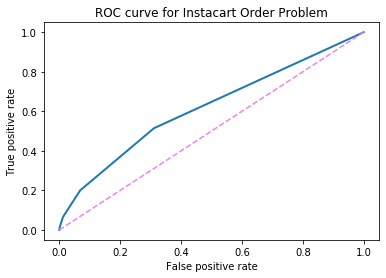

In [262]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Instacart Order Problem');
print("ROC AUC score = ", roc_auc_score(y_val, nb.predict_proba(X_val)[:,1]))
# accuracy : 0.7422182393988519

### XGBoost

In [326]:
# run xgb on unadjusted X-train data
model=xgb.XGBClassifier()

In [ ]:
model.fit(X_train,y_train)

In [205]:
# f1 score for unadjusted data
model.score(X_val,y_val)
y_predict_xgb = model.predict(X_val)
f1_score(y_val, y_predict_xgb)
# f1 : 0.20148387422399433

0.20148387422399433

## GridSearch CV: Random Forest

In [310]:
from imblearn.pipeline import make_pipeline, Pipeline

rf = RandomForestClassifier()

steps = [('rf',rf)]
pipeline = Pipeline(steps)

In [316]:
rf_grid = {
        'rf__random_state':[88],
          'rf__n_estimators': [300,500,800,1000],
#         'rf__criterion': ['gini', 'entropy'],
#         'rf__class_weight':[None,'balanced'],
           'rf__max_depth':[None,2,3,4]
         }
        

In [317]:
grid1 = GridSearchCV(pipeline, param_grid=rf_grid, scoring = 'f1',cv=3)

In [318]:
grid1.fit(X_under,y_under)
print(grid1.best_params_)
print(grid1.best_score_)
# undersampling params: {'rf__max_depth': 2, 'rf__n_estimators': 300, 'rf__random_state': 88}
# undersampling best f1: 0.6680537848141284

{'rf__max_depth': 2, 'rf__n_estimators': 500, 'rf__random_state': 88}
0.6693534580781666


In [88]:
from sklearn import metrics

In [89]:
sorted(metrics.SCORERS.keys())


['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

## GridSearchCV: XGBoost

In [446]:
def xgboost_run(X,y,X_val,y_val):
    xgb_model = xgb.XGBClassifier(learning_rate=0.01, max_depth=3)
    xgb_model.fit(X,y)
    #xgb_model.predict(X_val)
    y_pred_th = (xgb_model.predict_proba(X_val)[:,1] >= 0.6).astype(bool)
    f1score = metrics.f1_score(y_val, y_pred_th)
    accuracy_xgb = xgb_model.score(X_val, y_val)
    recall_xgb = metrics.recall_score(y_val, y_pred_th)
    return f1score, accuracy_xgb, recall_xgb

In [447]:
xgboost_run(X_under,y_under,X_te,y_te)
# (0.24079396663964428, 0.9087217201252289, 0.15014858613400325)
# Final Test : (0.4149728554627639, 0.7905510123087708, 0.5139628637848336)

(0.4149728554627639, 0.7905510123087708, 0.5139628637848336)

### F1 Threshold Optimization

In [454]:
xgb_model.fit(X_under, y_under)
y_pred = xgb_model.predict_proba(X_val)
precision, recall, thresholds = metrics.precision_recall_curve(y_val, y_pred[:,1])
#y_pred = xgb_model.predict_proba(X_te)



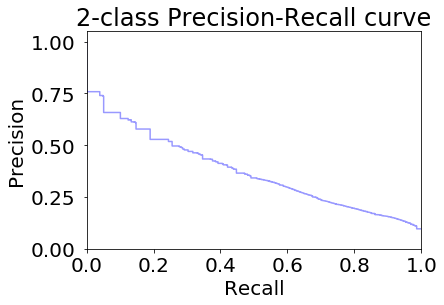

In [462]:
xgb_model.fit(X_under, y_under)
y_pred = xgb_model.predict_proba(X_val)
precision, recall, thresholds = metrics.precision_recall_curve(y_val, y_pred[:,1])
 
thresholds = np.append(thresholds, 1)
f1_scores = 2*(precision*recall)/(precision+recall)
plt.step(recall, precision, color='b', alpha=0.4, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')
plt.show()

Threshold cutoff:  0.6410582065582275
Max F1-score at cut-off :  0.41319321669518977


Text(0.5, 1.0, 'F1 Threshold Optimization')

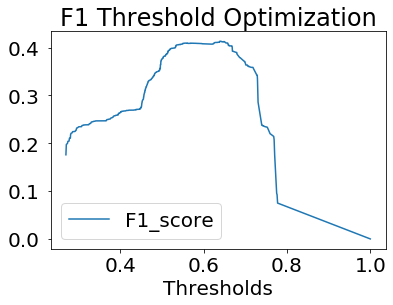

In [468]:
scrs = pd.DataFrame({'precision' : precision, 'recall' : recall, 'Thresholds' : thresholds, 'F1_score':f1_scores})
print("Threshold cutoff: ",scrs.loc[scrs['F1_score'] == scrs.F1_score.max(),'Thresholds'].iloc[0])
print("Max F1-score at cut-off : ",scrs.F1_score.max())
scrs.plot(x='Thresholds', y='F1_score')
plt.title('F1 Threshold Optimization')

In [327]:
steps2 = [('xgb',model)]
pipeline = Pipeline(steps2)


In [325]:
xgb_grid = {
           'xgb__max_depth':[3,4,5],
           'xgb__learning_rate':[0.01,0.03,0.05,0.1]
          }


In [328]:
grid2 = GridSearchCV(pipeline, param_grid=xgb_grid, scoring = 'f1', cv = 3)
   
grid2.fit(X_under, y_under)
print(grid2.best_params_)
print(grid2.best_score_)
# smote best_params - {'smt__random_state': 42, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3}
# smote best f1 : 0.35786404849675485
# undersampled best_params - {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3}
# undersampled best f1 : 0.6185822324502741

{'xgb__learning_rate': 0.01, 'xgb__max_depth': 3}
0.6186316947784807


In [121]:
X_train_smote, y_train_smote = SMOTE(random_state=42).fit_sample(X_train,y_train)


### XGBoost with SMOTE & best_params -- best F1 Score

In [309]:
## Xgboost scores
model2=xgb.XGBClassifier(learning_rate=0.01,max_depth=3)
model2.fit(X_under,y_under)
model2.score(X_val,y_val)
y_predict_xgb = model2.predict(X_val)
f1_score(y_val, y_predict_xgb)
# smote - f1 : 0.3635474860335196

0.37570975720207617

ROC AUC score =  0.7761511187987428


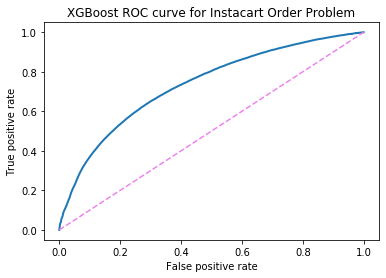

In [212]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('XGBoost ROC curve for Instacart Order Problem');
print("ROC AUC score = ", roc_auc_score(y_val, model2.predict_proba(X_val)[:,1]))
# smote - roc auc : 0.7761511187987428


## Comparison of Models: F1 Scores on Train Data

In [434]:
xgb_model=xgb.XGBClassifier(learning_rate=0.01,max_depth=3,error@t=0.2)
lr_model = LogisticRegression(solver="liblinear",C=0.01)
nb_model = GaussianNB()
# knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier(n_estimators=500,max_depth=2)
ada_model = ensemble.AdaBoostClassifier()

model_names = ["xgb_model","lr_model", "nb_model", "rf_model", "ada_model"]
models = [xgb_model,lr_model, nb_model, rf_model, ada_model]

SyntaxError: keyword can't be an expression (<ipython-input-434-dbe256a13c40>, line 1)

In [383]:
# ## Loop through each type of model and record cv score
f1_scores = []
for m in models:
    model_score = cross_val_score(m, X_under, y_under, cv=3, scoring='f1')
    f1_scores.append([np.mean(model_score), np.std(model_score)])
# look at st dev
model_scores = zip(model_names, f1_scores)
print(model_scores)

In [385]:
print(f1_scores)

[[0.6186316947784807, 0.06410084265749631], [0.639986992326398, 0.052066220454200104], [0.43004256223637416, 0.10590971516415291], [0.6701397613435461, 0.046823117514495353], [0.5976726978957042, 0.06745307074437784]]


### Plotting Multiple ROC

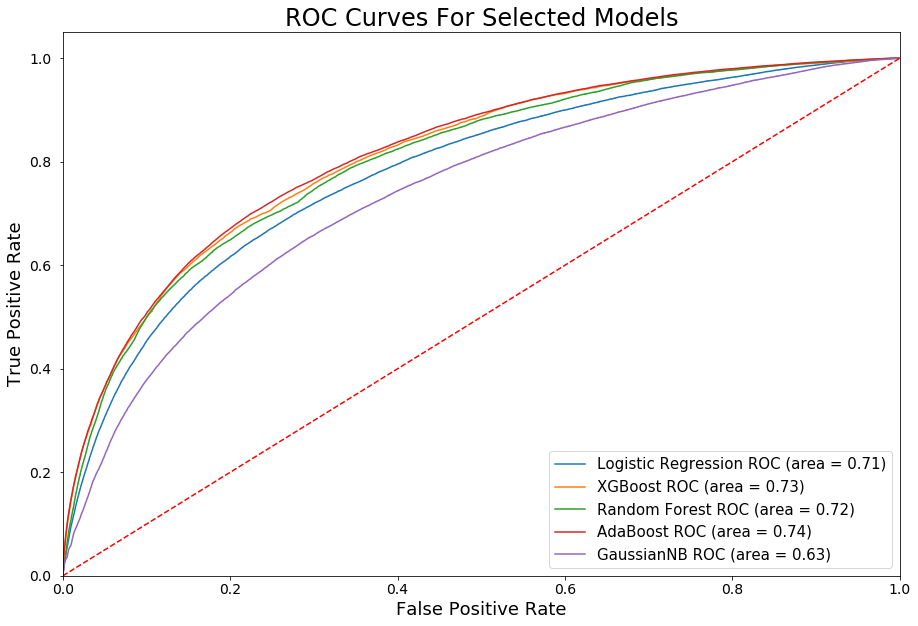

In [448]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

roc_fig = plt.figure(figsize=(15,10))

# list of models to plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(solver='liblinear',C=0.01),
},
{
    'label': 'XGBoost',
    'model': xgb.XGBClassifier(learning_rate=0.01,max_depth=3),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(n_estimators=500,max_depth=2),
},
{
    'label': 'AdaBoost',
    'model': ensemble.AdaBoostClassifier(),
},
{
    'label': 'GaussianNB',
    'model': GaussianNB(),
}
    
]

#iterates through models list
f1_scores = []
for m in models:
    model = m['model'] # select the model
    model.fit(X_under, y_under) # train the model
    y_pred=model.predict(X_val) # predict the test data
# compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_val, model.predict_proba(X_val)[:,1])
# calculate area under the curve to display on the plot, plus f1
    auc = metrics.roc_auc_score(y_val,model.predict(X_val))
    f1score = metrics.f1_score(y_val, model.predict(X_val))
    f1_scores.append(f1score)
# now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
    
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right",prop={'size': 15})
plt.rcParams.update({'font.size': 20})
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curves For Selected Models')
plt.show()
roc_fig.savefig('instacart_roc_auc_3.svg', transparent=True)

In [391]:
print(f1_scores)
# val scores, fit on undersampled - LR 0.3388, XGB 0.3645, RF 0.3521, NB G 0.3226
# LR 0.3349, XGB 0.3757, RF 0.3706, ADA 0.3603, NB 0.3226
# select XGB & RF to tune

[0.33494585444513225, 0.37570975720207617, 0.3705728777503318, 0.36033705602627053, 0.3225671841094976]


## Final Models: XGBoost + Random Forest on Test Data

In [350]:
# final models with params from gridsearchCV
final_models =[
{
    'label': 'XGBoost',
    'model': xgb.XGBClassifier(learning_rate=0.01,max_depth=3),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(n_estimators=500,max_depth=2),
}]

final_f1_scores = []
recall_scores = []
precision_scores = []
for m in final_models:
    model = m['model'] # select the model
    model.fit(X_under, y_under)
    y_pred=model.predict(X_te) # predict the test data
    f1score_te = metrics.f1_score(y_te, model.predict(X_te))
    recall_te = metrics.recall_score(y_te,model.predict(X_te))
    precision_te = metrics.precision_score(y_te,y_pred)
    precision_scores.append(precision_te)
    recall_scores.append(recall_te)
    final_f1_scores.append(f1score_te)
    

In [333]:
print(label,': f1 ',final_f1_scores)
# XGBoost : 0.38526025813253517
# RF : 0.3789319178713454

[0.38526025813253517, 0.3789319178713454]


In [349]:
print(recall_scores)


[0.6666862843186299, 0.6579171938910632]


In [351]:
print(precision_scores)

[0.2709043297341895, 0.26626992662699267]


In [ ]:
rf_test = RandomForestClassifier(n_estimators=500,max_depth=2)
rf_test.fit(X_under,y_under)
rf_test.predict(X_te)

In [431]:
xgb_test.score(X_te,y_te)


0.7905510123087708

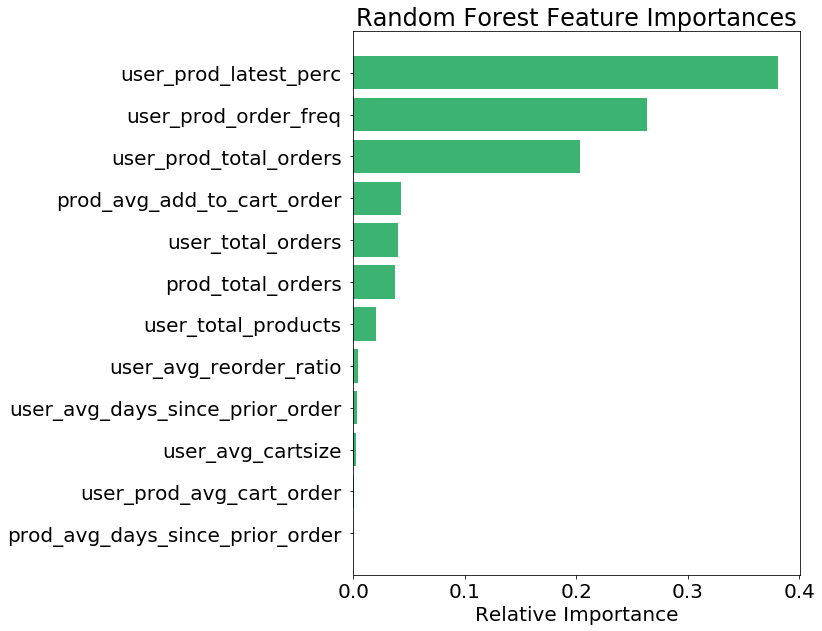

In [418]:
test_features = X_under.columns
test_importances = rf_test.feature_importances_
indices = np.argsort(test_importances)

plt.figure(figsize=(8,10))
plt.title('Random Forest Feature Importances')
plt.barh(range(len(indices)), test_importances[indices], color='mediumseagreen', align='center')
plt.yticks(range(len(indices)), [test_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [400]:
xgb_test = xgb.XGBClassifier(learning_rate=0.01,max_depth=3)
xgb_test.fit(X_under,y_under)
y_pred_xgb = xgb_test.predict(X_te)
xgb_prob_test = []
# for probs, pred in zip(xgb_test.predict_proba(X_te), y_pred_xgb):
#     print(probs,pred)
#     xgb_prob_test.append(probs[pred])
y_pred_proba = xgb_test.predict_proba(X_te)[:,1]

In [401]:
test_df = df_test.copy()
test_df['model_prob_1'] = y_pred_proba
test_df['y_pred_xgb'] = y_pred_xgb

In [402]:
test_df['y_te'] = y_te

In [ ]:
test_df.head()

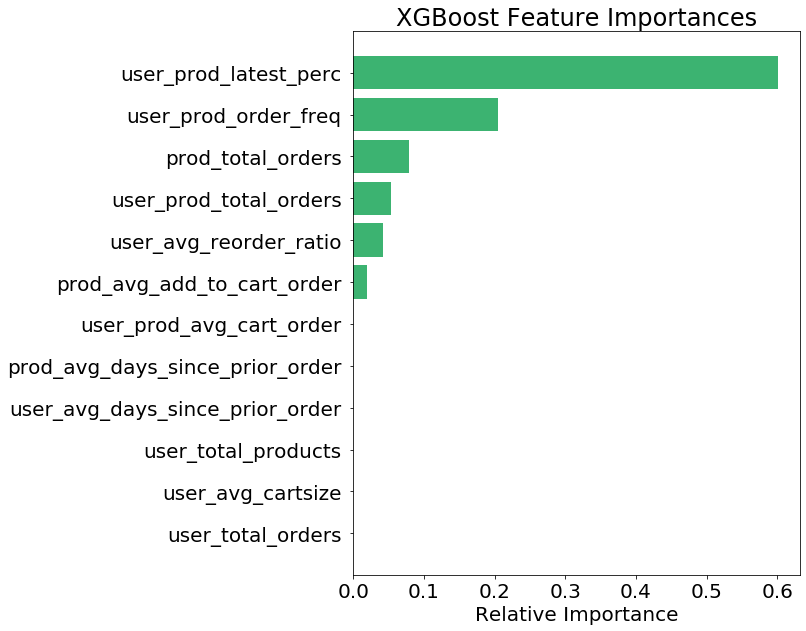

In [417]:
test_features = X_under.columns
xgb_importances = xgb_test.feature_importances_
indices = np.argsort(xgb_importances)

plt.figure(figsize=(8,10))
plt.title('XGBoost Feature Importances')
plt.barh(range(len(indices)), xgb_importances[indices], color='mediumseagreen', align='center')
plt.yticks(range(len(indices)), [test_features[i] for i in indices])
plt.rcParams['ytick.major.pad']='8'
plt.xlabel('Relative Importance')
plt.show()

In [380]:
metrics.confusion_matrix(y_te,y_pred_xgb)

array([[250243,  60975],
       [ 11327,  22656]])

In [379]:
metrics.confusion_matrix(y_te,rf_test.predict(X_te))

array([[250107,  61111],
       [ 11773,  22210]])

In [471]:
# Print confusion matrix for kNN NO undersampling
def make_confusion_matrix_test(model, threshold=0.6):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_te)[:, 1] >= threshold)
    order_confusion = confusion_matrix(y_te, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(order_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['wont order', 'will_order'],
           yticklabels=['wont_order', 'will_order']);
    plt.title('XGBoost: Test Confusion Matrix')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

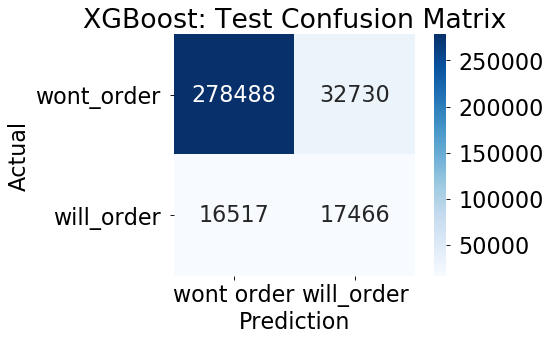

In [472]:
make_confusion_matrix_test(xgb_model,threshold=0.6)